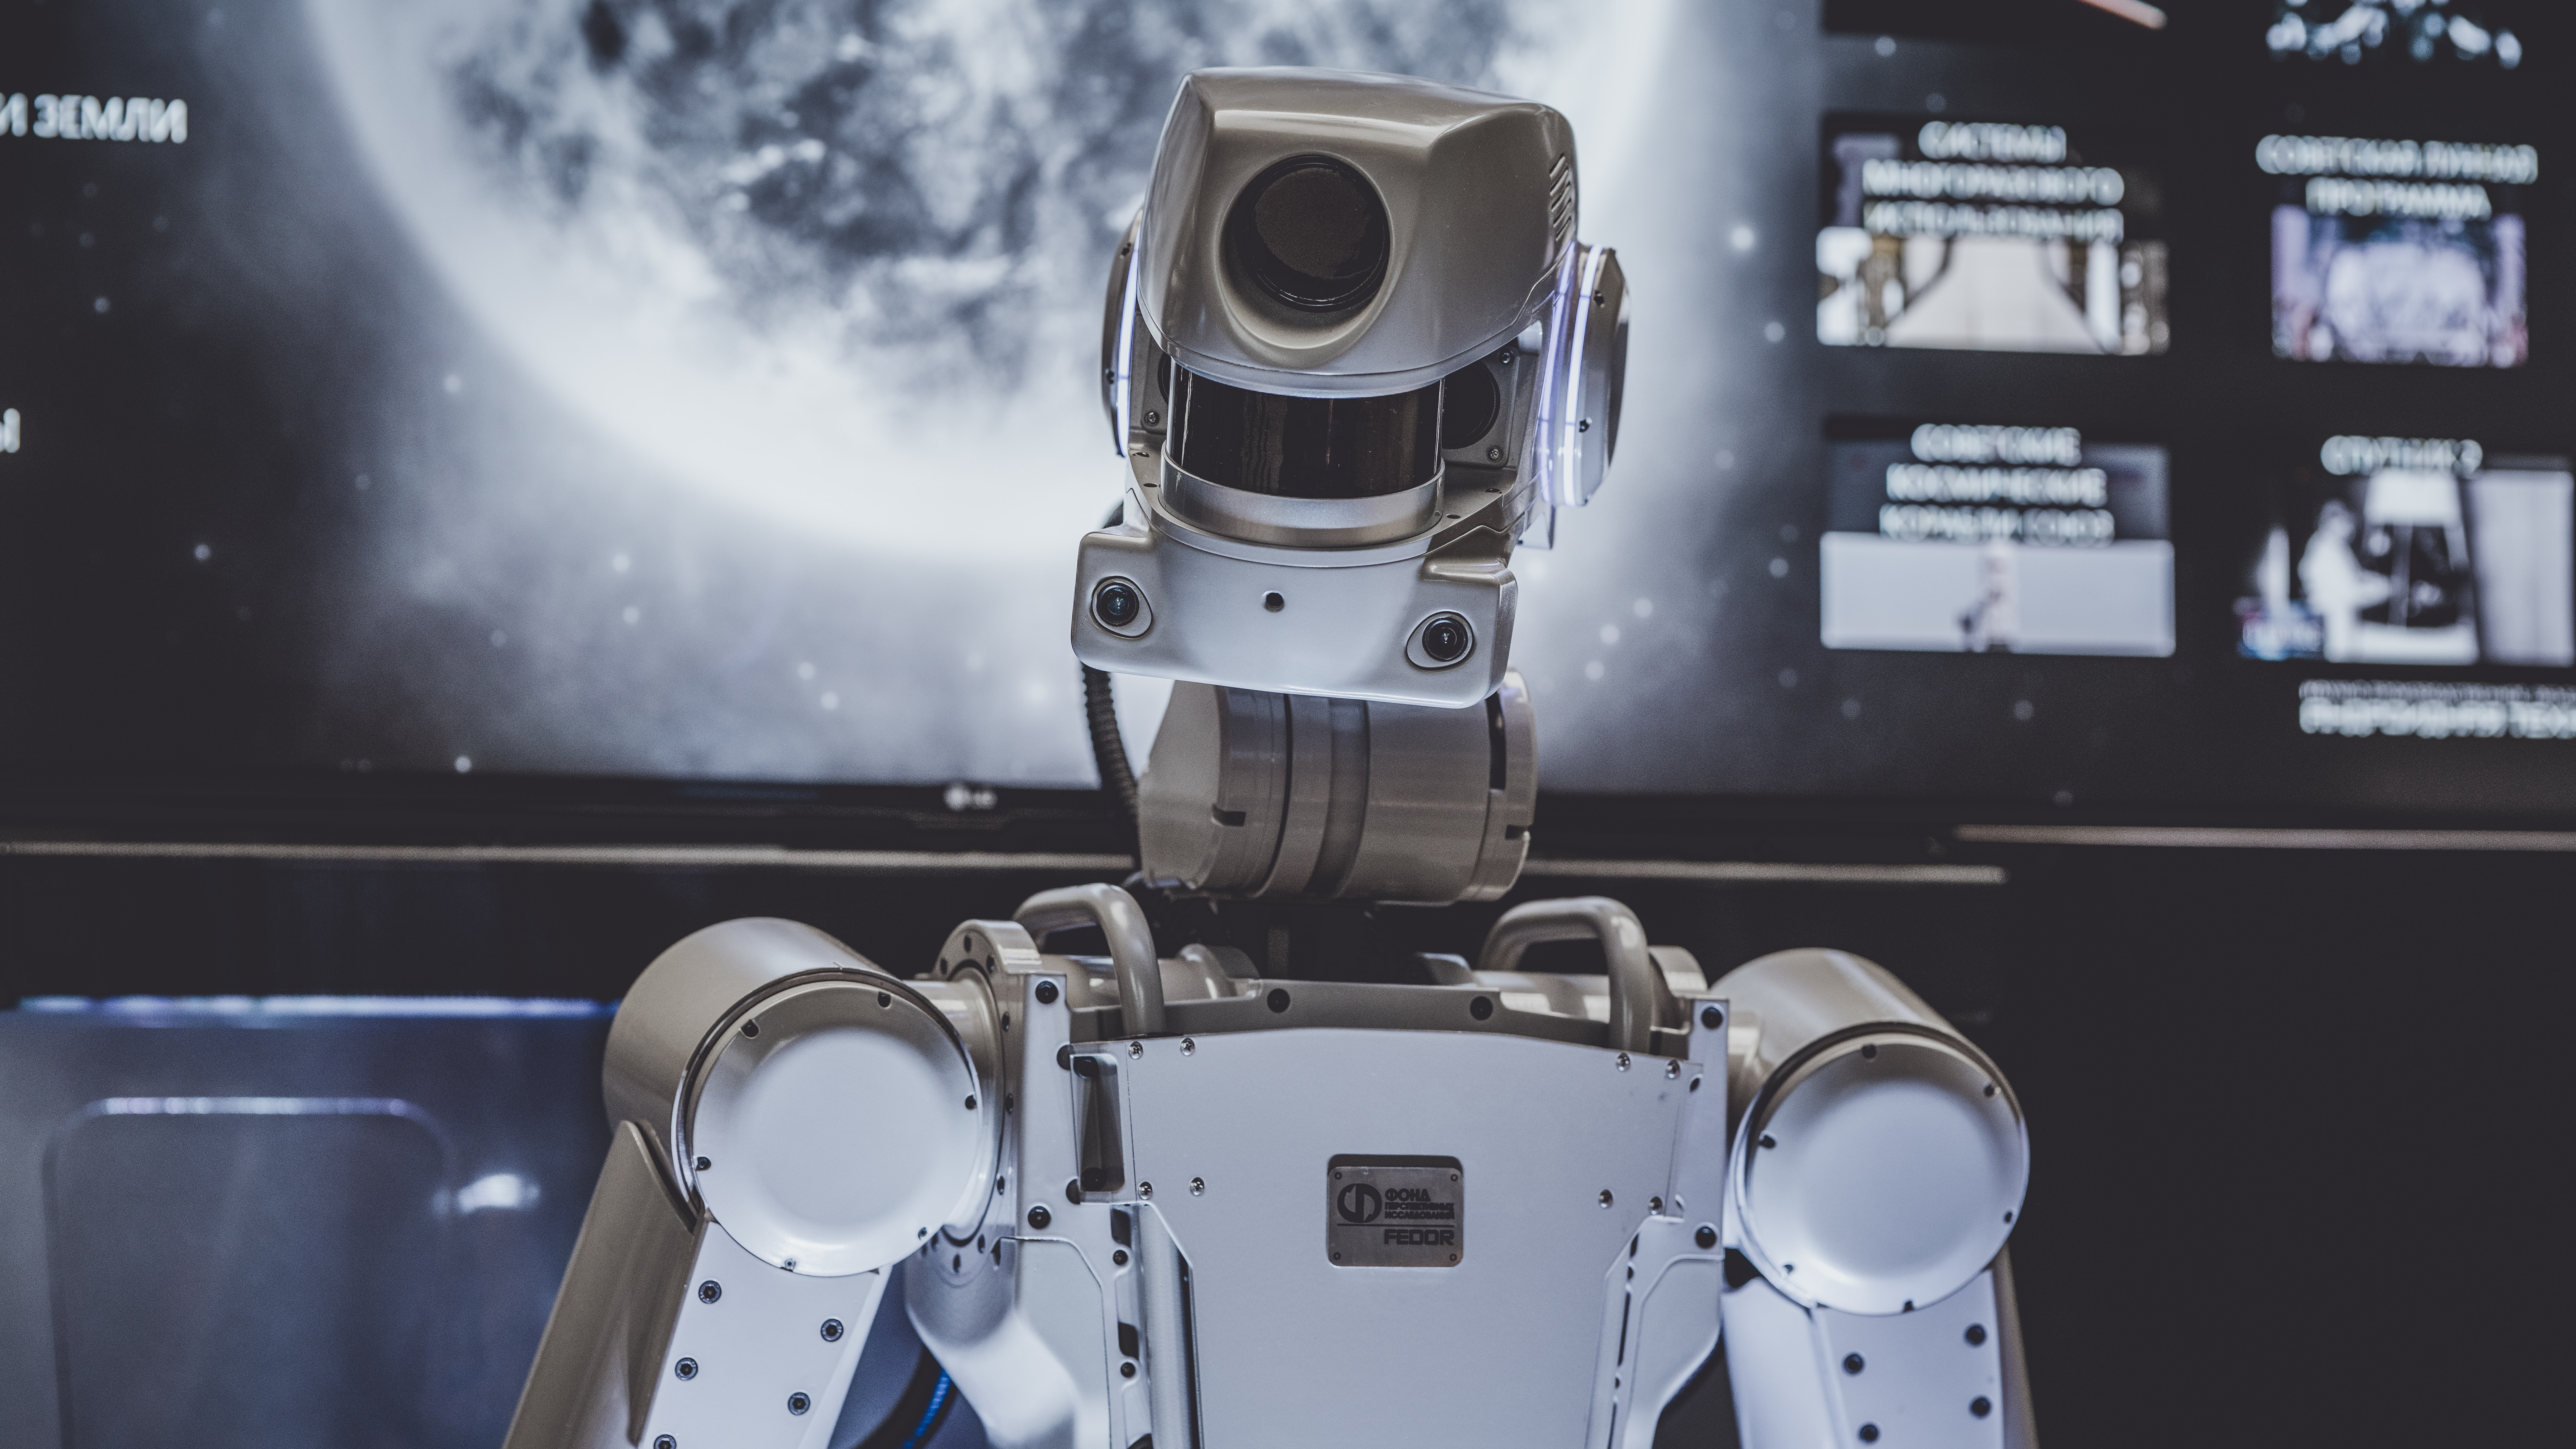

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Flatten , Dropout


**Creating global path variables for train and validation sets.**

In [2]:
TRAIN_DIR = '/content/drive/MyDrive/seg_train'
VALID_DIR = '/content/drive/MyDrive/seg_test'

**Creating image generators for train and validationsets.**

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, height_shift_range = 0.2, width_shift_range = 0.2, shear_range = 0.2, 
                                   zoom_range = 0.2, horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

**Let's load the image data from train and validation directories.**

In [4]:
train_set = train_datagen.flow_from_directory(directory = TRAIN_DIR, target_size = (150, 150), class_mode = 'categorical')
valid_set = valid_datagen.flow_from_directory(directory = VALID_DIR, target_size = (150, 150), class_mode = 'categorical')

Found 14054 images belonging to 6 classes.
Found 3007 images belonging to 6 classes.


**Defining the ground truth labels for test set, reverse label dictionary and define the number of classes.**

In [5]:
NUM_CLASSES = train_set.num_classes - 1
y_test = valid_set.labels.astype(dtype = np.float32)
LABEL_DICTIONARY = dict([(value, key) for key, value in train_set.class_indices.items()])

**Creating callbacks with function**

In [6]:
def callbacks (model_path , monitoring = "val_loss" , patience = 5) : 
  early = EarlyStopping(monitor = monitoring , patience=patience,verbose = 1 , restore_best_weights=True)
  check = ModelCheckpoint(filepath=model_path , monitor=monitoring , verbose=1 , save_best_only=True)

  callbacks = [early , check]

  return callbacks

**Modelling: CNN model with Sequential API**

In [7]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a CNN model with Sequential API
model_1 = Sequential(layers = [
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3)),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Flatten(),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = 6, activation = 'softmax')
], name = 'Sequential_CNN')

# Compiling the model
model_1.compile(optimizer = Adam(), loss = CategoricalCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_1 = model_1.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = callbacks(model_path = f'{model_1.name}.h5'),
                               verbose = 1)

Epoch 1/100
440/440 [==============================] - ETA: 0s - loss: 1.4990 - accuracy: 0.3537
Epoch 1: val_loss improved from inf to 1.16382, saving model to Sequential_CNN.h5
440/440 [==============================] - 4258s 10s/step - loss: 1.4990 - accuracy: 0.3537 - val_loss: 1.1638 - val_accuracy: 0.4925
Epoch 2/100
440/440 [==============================] - ETA: 0s - loss: 1.1995 - accuracy: 0.5191
Epoch 2: val_loss improved from 1.16382 to 0.97975, saving model to Sequential_CNN.h5
440/440 [==============================] - 109s 247ms/step - loss: 1.1995 - accuracy: 0.5191 - val_loss: 0.9797 - val_accuracy: 0.5933
Epoch 3/100
440/440 [==============================] - ETA: 0s - loss: 1.1154 - accuracy: 0.5624
Epoch 3: val_loss improved from 0.97975 to 0.87569, saving model to Sequential_CNN.h5
440/440 [==============================] - 108s 244ms/step - loss: 1.1154 - accuracy: 0.5624 - val_loss: 0.8757 - val_accuracy: 0.6285
Epoch 4/100
440/440 [==============================

In [8]:
model_1.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 38, 38, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 38, 38, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 64)    

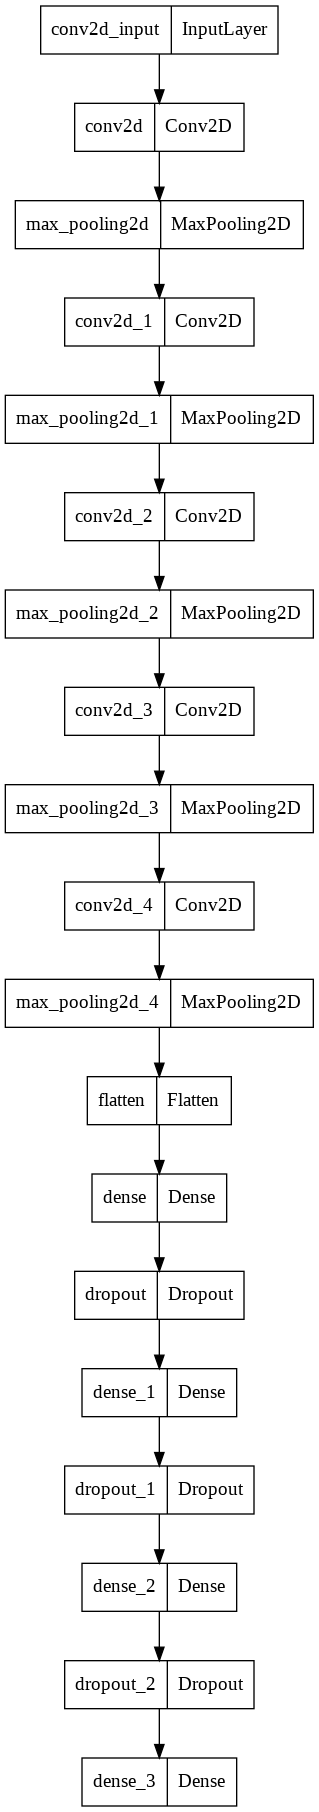

In [9]:
from tensorflow.keras.utils import plot_model
plot_model(model = model_1, to_file = f'{model_1.name}.png')

**Visualizing model performance**

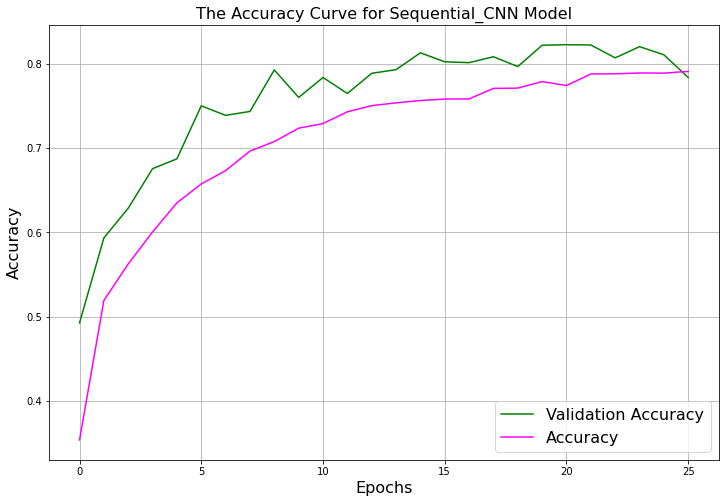

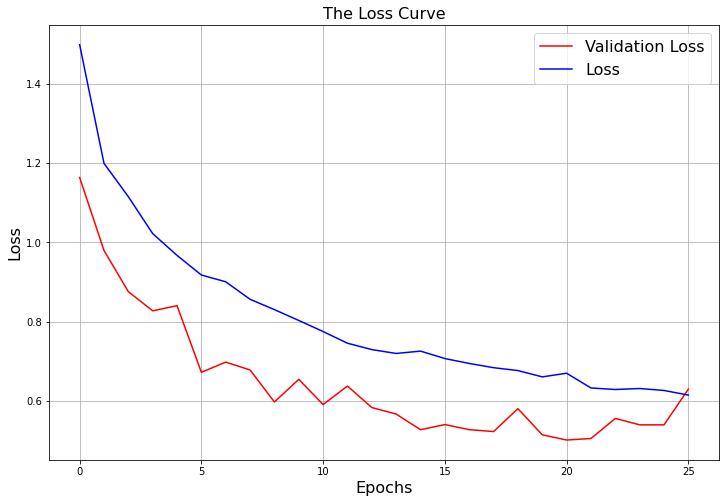

In [10]:
val_accuracy = model_training_1.history["val_accuracy"]
accuracy = model_training_1.history["accuracy"]

plt.figure(figsize = (12,8))
plt.plot(val_accuracy , label = "Validation Accuracy" , c = "green")
plt.plot(accuracy , label = "Accuracy" , c = "magenta")
plt.title(f"The Accuracy Curve for {model_1.name} Model" , fontsize = 16)
plt.ylabel("Accuracy" , fontsize = 16)
plt.xlabel("Epochs" , fontsize = 16)
plt.legend(loc = "best" , fontsize = 16)
plt.grid()
plt.show()

val_loss = model_training_1.history["val_loss"]
loss = model_training_1.history["loss"]

plt.figure(figsize = (12,8))
plt.plot(val_loss , label = "Validation Loss" , c = "red")
plt.plot(loss , label = "Loss" , c = "blue")
plt.title("The Loss Curve" , fontsize = 16)
plt.ylabel("Loss" , fontsize = 16)
plt.xlabel("Epochs" , fontsize = 16)
plt.grid()
plt.legend(loc = "best" , fontsize = 16)
plt.show()

**Accuracy score and loss**

In [11]:
from sklearn.metrics import accuracy_score

accuracy_score = model_1.evaluate(valid_set)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
 
print("Loss: ",accuracy_score[0])

94/94 [==============================] - 6s 68ms/step - loss: 0.5012 - accuracy: 0.8224
[0.501232385635376, 0.8224143385887146]
Accuracy: 82.2414%
Loss:  0.501232385635376


In [12]:
x , y = next(valid_set)
x.shape

(32, 150, 150, 3)

**Predictions**

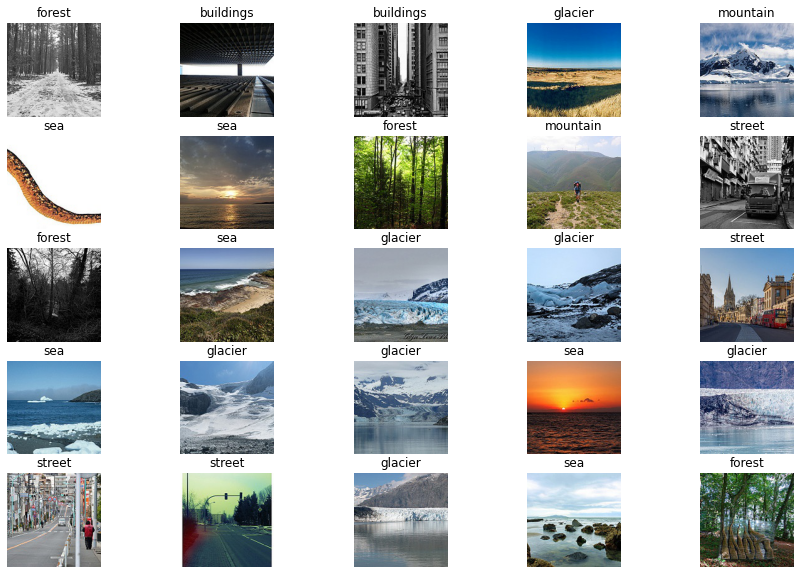

In [13]:
class_names = ["buildings" , "forest" , "glacier" , "mountain" , "sea" , "street"]
def plot_images(img, labels):
    plt.figure(figsize=[15, 10])
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
plot_images(x,y)